### Шаг 1. 

Выбранный датасет: сайт кинопоиска

А именно фильмы у которых есть хотя бы 100000 оценок на Кинопоиске ($\approx$ 800 штук) (хотя, конечно, брать от 100к оценок получится немного нерепрезентативно, но можно скзаать, что датасет будет состоять из 800 самых популярных фильмов по мнению пользователей кинопоиска)

Соотвественно столбцы это средняя оценка на кинопоиске, количество оценок, тоже самое на IMDb, на страничках фильмов: год, страна, жанр, сборы, режисер и т. д.

Для начала заходим на навигатор кинопоиска, затем ставим ограничение по количеству оценок, то что это должен быть фильм, и сбрасываем остальные ограничения. Переходим на 2 страничку, для того чтобы понять как выглядит ссылка для рызных страниц. Получаем ссылку из адресной строки и меняем в ней после page 2 на 1. 

https://www.kinopoisk.ru/top/navigator/m_act[num_vote]/10000/m_act[rating]/1%3A/m_act[is_film]/on/order/rating/page/1/#results

In [599]:
import requests as rq
import pandas as pd
from bs4 import BeautifulSoup
import time
import numpy as np
from tqdm.notebook import tqdm
from fake_useragent import UserAgent

r = rq.get(
    'https://www.kinopoisk.ru/top/navigator/m_act[num_vote]/100000/m_act[rating]/1%3A/m_act[is_film]/on/order/rating/perpage/50/page/1/#results')
r

<Response [200]>

Замечаем, что нас пока что пускают на сайт и парсим красивым супом страничку.

In [693]:
web = BeautifulSoup(r.text, 'html.parser')

Теперь нам надо определить как выглядит тег в котором лежит отдельный фильм.

Понимаем, что это div с атрибутом class="item _NO_HIGHLIGHT_"

Заберем их пока что с первой странички


In [601]:
list_of_films_from_first_page = web.findAll('div', {"class": "item _NO_HIGHLIGHT_"})
display(list_of_films_from_first_page[0])

<div class="item _NO_HIGHLIGHT_" id="tr_326">
<div class="poster_and_flags">
<div class="poster"><a href="/level/1/film/326/"><img alt="Побег из Шоушенка (The Shawshank Redemption1994)" class="flap_img" src="https://st.kp.yandex.net/images/sm_film/326.jpg" title="/images/sm_film/326.jpg"/></a>
<div class="playTrailer movie-play-trailer-button js-discovery-trailer" data-film-id="326"></div>
</div>
<div class="flags"> <div class="flag flag1" style="float: left; margin: 0 2px 5px 0">
<a href="/lists/m_act[country]/1/" title="США"></a>
</div>
</div>
<table border="0" cellpadding="0" cellspacing="0" width="100%"><tr><td>
<span align="left" style="position: relative">
<span style="position: absolute; z-index: 20; visibility: visible; left:0px;">
<span id="handler_div_recom_448"></span>
</span>
</span>
</td></tr></table>
</div>
<div class="info">
<div class="name"><a href="/level/1/film/326/">Побег из Шоушенка</a> <span>The Shawshank Redemption (1994) <nobr>142 мин.</nobr></span></div>
<span 

C этого дива будем забирать название, ссылку на страницу фильма, оценку на кинопоиске и IMDb и количество этих оценок.

Имя лежит в теге a, который лежит в диве с классом name, там же лежит ссылка вида href="/level/1/film/326/", перейдем по ней и заметим что мы находимся на https://www.kinopoisk.ru/film/326/, следовательно для того чтобы получить ссылку на фильм надо взять то что лежит после /level/1 и подставить после https://www.kinopoisk.ru

Оценка на кинопоиске и их количество лежат в спанах в дивах с классом numVote, причем количество имеет ужасный вид: (30&nbsp;560), значит будем удалять скобки и & nbsp;

Рядом в классе imdb лежат оценки и их количество на IMDb, причем оценка имеет вид: IMDb: 2.70, что тоже надо будет фиксить

На страничке о фильме нас интересует раздел О фильме, соотвественно див с data-test-id="encyclopedic-table"

Каждая строка с информацией это див с data-tid="a25321e6"

Левая часть строки (название парметра) лежит в первом внутреннем диве
Информация о парметре лежит в внутренних тегах a или div внутри второго внутреннего дива

Информацию о фильме будем хранить в виде списка, где первые 5 парметров с начальной страницы записаны в виде самого значения, а остальные в виде "<название парметра> <значение (список значений)>"

Случилось неожиданное (ну наверное с таким сайтом стоило такого ожидать) и сайтик нас кидает на капчу, через несколько открытых страниц, поэтому будем заполнять поочередно через разные прокси и т. д. (стоит надеяться что "попяцот" наберется)

Необходимо, по крайней мере будет удобнее, создать список из списков фильмов, чтобы потом пройтись по ним циклом в котором будут меняться прокси как бы автоматически (так как делать это 20 раз не совсем чтобы удобно)


In [12]:
list_of_films_from_pages = []
page_counter = 1

In [145]:
ua = UserAgent()
proxies = {'https': '144.217.72.194:32769'}
for i in tqdm(range(1, 16)):
    page_link = f'https://www.kinopoisk.ru/top/navigator/m_act[num_vote]/100000/m_act[rating]/1%3A/m_act[is_film]/on/order/rating/page/{i}/#results'
    page = BeautifulSoup(rq.get(page_link, headers={'User-Agent': ua.chrome}, proxies=proxies).text,
                         'html.parser')
    list_of_films_from_other_pages[i - 1] = page.findAll('div', {"class": "item _NO_HIGHLIGHT_"})
    time.sleep(5)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
list_of_films_from_pages

Теперь пройдемся двойным циклом по списку списков фильмов используя список из прокси с сайта http://free-proxy.cz/ru/proxylist/country/all/https/ping/all (вообще было бы по заданию спарсить это, но 5 раз скопировать и вставить в файлик просто быстрее), которые будем менять при ошибке и пойдем спать

In [27]:
page_counter = 0
film_counter = 0

In [ ]:
f = open('proxies.txt', 'r')
proxies_list = f.read().split('\n')
proxies_counter = 0

In [ ]:
ua = UserAgent(verify_ssl=False)
c = 0
proxies = {'https': proxies_list[proxies_counter % len(proxies_list)]}
for list_of_films_from_one_page in tqdm(list_of_films_from_pages[page_counter:]):
    for film in tqdm(list_of_films_from_one_page[film_counter:]):
        while True:
            try:
                ua = UserAgent(verify_ssl=False)
                teg_a = film.find('div', {'class': 'name'}).find('a')
                link_to_film_page = 'https://www.kinopoisk.ru' + teg_a.get('href')[8:]
                name_of_film = ('Название', teg_a.text)
                mark_n_count_kinopoisk = film.find('div', {'class': 'numVote'}).find('span')
                mark_kinopoisk = ('Средняя оценка на Кинопоиск', float(mark_n_count_kinopoisk.text[:5]))
                count_kinopoisk = ('Количество оценок на Кинопоиск',
                                   int(mark_n_count_kinopoisk.find('span').text[1:-1].replace('\xa0', '')))
                mark_n_count_imdb = film.find('div', {'class': 'imdb'})
                if mark_n_count_imdb is None:
                    mark_imdb = ('Средняя оценка на IMDb', None)
                    count_imdb = ('Количество оценок на IMDb', None)
                else:
                    mark_imdb = ('Средняя оценка на IMDb', float(mark_n_count_imdb.text[6:10]))
                    count_imdb = ('Количество оценок на IMDb',
                                  int(mark_n_count_imdb.find('span').text.replace('\xa0', '')))
                r = rq.get(link_to_film_page, headers={'User-Agent': ua.chrome}, proxies=proxies, timeout=5)
                film_page = BeautifulSoup(r.text, 'html.parser')
                film_info = []
                for row in film_page.find('div', {'data-test-id': 'encyclopedic-table'}).find_all('div', {
                    'data-tid': 'a25321e6'}):
                    param, value = row
                    info = []
                    for i in value.find_all('div'):
                        info.append(i.text.replace('\xa0', ''))
                    for i in value.find_all('a'):
                        info.append(i.text.replace('\xa0', ''))
                    if info[-1] == 'слова' or info[-1] == '...':
                        info = info[:-1]
                    if len(info) > 0 and len(info[0].split(',')) == len(info) - 1:
                        info = info[1:]
                    if len(info) == 1:
                        info = info[0]
                    film_info.append((param.text, info))
                time.sleep(3)
                info_of_films.append([name_of_film, mark_kinopoisk, count_kinopoisk, mark_imdb, count_imdb, *film_info])
                film_counter += 1
                c += 1
                break
            except Exception as e:
                if c == 0:
                    proxies_list.pop(proxies_counter % len(proxies_list))
                proxies_counter += 1
                с = 0
                proxies = {'https': proxies_list[proxies_counter % len(proxies_list)]}
                print(str(e))
    page_counter += 1
    film_counter = 0

In [193]:
proxies_list.pop(proxies_counter % len(proxies_list))

'134.122.84.79:3128'

In [200]:
len(info_of_films)

795

Теперь у нас есть все 795 фильмов, информация о которых записана в списках из кортежей

Теперь соберем все возможные столбцы

In [210]:
columns = []
for film in info_of_films:
    for row in film:
        columns.append(row[0])
table = {i: [] for i in list(set(columns))}
table

{'Цифровой релиз': [],
 'Бюджет': [],
 'Количество оценок на IMDb': [],
 'Страна': [],
 'Монтаж': [],
 'Сборы в России': [],
 'Продюсер': [],
 'Время': [],
 'Сборы в США': [],
 'Рейтинг MPAA': [],
 'Оператор': [],
 'Сборы в мире': [],
 'Зрители': [],
 'Релиз на Blu-ray': [],
 'Жанр': [],
 'Художник': [],
 'Маркетинг': [],
 'Слоган': [],
 'Количество оценок на Кинопоиск': [],
 'Ре-релиз (РФ)': [],
 'Средняя оценка на Кинопоиск': [],
 'Название': [],
 'Режиссер': [],
 'Возраст': [],
 'Сценарий': [],
 'Премьера в мире': [],
 'Композитор': [],
 'Директор фильма': [],
 'Средняя оценка на IMDb': [],
 'Премьера в Росcии': [],
 'Год производства': [],
 'Релиз на DVD': []}

In [ ]:
for film in info_of_films:
    keys = list(i[0] for i in film)
    values = list(i[1] for i in film)
    for key in table.keys():
        if key in keys:
            table[key].append(values[keys.index(key)])
        else:
            table[key].append(None)

In [632]:
dataset = pd.DataFrame.from_dict(table).set_index('Название').sort_values('Год производства')
dataset

,Цифровой релиз,Бюджет,Количество оценок на IMDb,Страна,Монтаж,Сборы в России,Продюсер,Время,Сборы в США,Рейтинг MPAA,...,Режиссер,Возраст,Сценарий,Премьера в мире,Композитор,Директор фильма,Средняя оценка на IMDb,Премьера в Росcии,Год производства,Релиз на DVD
Название,,,,,,,,,,,,,,,,,,,,,
Унесенные ветром,None,$3977000,294790,США,None,None,Дэвид О. Селзник,222 мин. / 03:42,$189523031,PGрекомендуется присутствие родителей,...,"[Виктор Флеминг, Джордж Кьюкор, Сэм Вуд]",12+,"[Сидни Ховард, Оливер Х.П. Гаррет, Бен Хект]",15 декабря 1939,Макс Штайнер,None,8.10,None,1939,"7 августа 2002, «Мост-Видео»"
Римские каникулы,None,$1500000,129480,США,Роберт Свинк,None,"[Уильям Уайлер, Роберт Уайлер, Лестер Кениг]",118 мин. / 01:58,$5000000,None,...,Уильям Уайлер,6+,"[Далтон Трамбо, Йен МакЛеллан Хантер, Джон Дай...",20 августа 1953,Жорж Орик,None,8.00,None,1953,"9 декабря 2003, «Film Prestige»"
12 разгневанных мужчин,None,$340000,707165,США,Карл Лернер,None,"[Генри Фонда, Реджинальд Роуз, Джордж Джастин]",96 мин. / 01:36,None,None,...,Сидни Люмет,16+,Реджинальд Роуз,10 апреля 1957,Кенион Хопкинс,None,9.00,None,1956,None
В джазе только девушки,None,$2883848,248217,США,Артур П. Шмидт,None,"[Билли Уайлдер, И.А.Л. Даймонд, Доан Харрисон]",119 мин. / 01:59,$25000000,None,...,Билли Уайлдер,12+,"[Билли Уайлдер, И.А.Л. Даймонд, Роберт Тёрен]",19 марта 1959,Адольф Дойч,None,8.20,None,1959,"19 февраля 2003, «DVD Магия»"
Психо,None,$806947,616212,США,Джордж Томазини,$39919,Альфред Хичкок,109 мин. / 01:49,$32000000,Rлицам до 17 лет обязательно присутствие взрос...,...,Альфред Хичкок,16+,Роберт Блох,16 июня 1960,Бернард Херрманн,None,8.50,«Иноекино»,1960,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Аферистка,«Вольга»,None,99150,Великобритания,Марк Экерсли,$830916,"[Бен Стиллман, Андреа Аджемиан, Дж. Блэйксон]",118 мин. / 01:58,None,Rлицам до 17 лет обязательно присутствие взрос...,...,Дж. Блэйксон,18+,Дж. Блэйксон,12 сентября 2020,Марк Канэм,None,6.30,«Вольга»,2020,None
Майор Гром: Чумной Доктор,None,None,2593,Россия,Александр Пузырёв,$4458320,"[Артем Габрелянов, Михаил Китаев, Ольга Филипук]",136 мин. / 02:16,None,None,...,Олег Трофим,12+,"[Артем Габрелянов, Роман Котков, Евгений Еронин]",None,Роман Селиверстов,None,6.50,«Дисней Студиос»,2021,None
Лига справедливости Зака Снайдера,«КиноПоиск HD»,$370000000,293515,Великобритания,"[Дэвид Бреннер, Карлос М. Кастильон, Доди Дорн]",None,"[Бен Аффлек, Уэсли Коллер, Марианн Дженкинс]",242 мин. / 04:02,None,Rлицам до 17 лет обязательно присутствие взрос...,...,Зак Снайдер,18+,"[Крис Террио, Джерри Сигел, Джо Шустер]",18 марта 2021,Junkie XL,None,8.10,None,2021,None


Ура, спустя много часов танцев с бубном по поводу парса, все готово

Главное сохраниться после миссии.

In [716]:
dataset.to_csv('kinopoisk.csv', sep='\t')

### Шаг 2

In [604]:
dataset.isnull().sum()

Цифровой релиз                    627
Бюджет                             62
Количество оценок на IMDb           0
Страна                              0
Монтаж                              5
Сборы в России                    165
Продюсер                           27
Время                               0
Сборы в США                        94
Рейтинг MPAA                       81
Оператор                            0
Сборы в мире                       36
Зрители                           183
Релиз на Blu-ray                  337
Жанр                                0
Художник                            2
Маркетинг                         717
Слоган                              0
Количество оценок на Кинопоиск      0
Ре-релиз (РФ)                     772
Средняя оценка на Кинопоиск         0
Режиссер                            0
Возраст                             1
Сценарий                            0
Премьера в мире                     7
Композитор                          0
Директор фил

Такие столбцы как Цифровой релиз, Маркетинг, Ре-релиз (РФ) и Директор фильма лучше будет удалить за отсутсвием данных в большинстве строк

В столбце бюджет пропуски в целом нельзя заполнить какой-нибудь медианой, так как реальный бюджет может сильно отличаться от медианы (многие из фильмов с пропущенным значением вообще из ссср, следовательно оценить их стоимость достаточно сложно), но так как всего 49 (см. ниже) фильмов имеют бюджет не в долларах и 62 не имеют оценки бюджета, то столбец можно отредактировать, оставив в нем только бюджеты в долларах и заменив все остальные значение на 0

Монтаж, продюсер, художник можно не заполнять, так как значения в этих столбцах составляют имена людей

Столбцы Рейтинг MPAA и Возраст связаны, следовательно их можно заполнить относительно друг друга или при отсутсвии обоих не заполнять, так как нельзя с точностью убедиться в реальном рейтинге различных фильмов. (R - 18, Pg-13 - 16, Pg - 12, 6, 0)

Релиз на DVD и Релиз на Blu-ray также следует оставить пустым, так как это означает что таких релизов не было.

Столбец зрители заполнен пустыми листами, так как на сайте эта строка обозначалась как троеточие, его стоит удалить.

В столбце Время следует оставить только количество минут (чтобы было числовое).

In [605]:
len(dataset) - dataset['Бюджет'].isnull().sum() - dataset['Бюджет'].apply(lambda x: '$' in str(x)).sum()

49

In [633]:
def ruleRate(x, y):
    if y is not None:
        if y[:5] == 'PG-13':
            return 'PG-13'
        if y[0] == 'R':
            return 'R'
        return 'PG'
    if x == '18+':
        return 'R'
    if x == '16+':
        return 'PG-13'
    return 'PG'


dataset.drop(['Цифровой релиз', 'Сборы в мире', 'Зрители', 'Маркетинг', 'Ре-релиз (РФ)', 'Директор фильма'],
             axis=1, inplace=True)
dataset['Бюджет'] = dataset['Бюджет'].apply(lambda x: int(str(x).replace('$', '').strip()) if '$' in str(x) else None)
dataset['Сборы в США'] = dataset['Сборы в США'].apply(
    lambda x: int(str(x).replace('$', '').strip()) if '$' in str(x) else None)
dataset['Время'] = dataset['Время'].apply(lambda x: int(x.split()[0]))
dataset['Возраст'] = dataset['Возраст'].fillna(value='18+')
dataset['Рейтинг MPAA'] = dataset.apply(lambda x: ruleRate(x['Возраст'], x['Рейтинг MPAA']), axis=1)
dataset['Год производства'] = dataset['Год производства'].apply(lambda x: int(x))
dataset = dataset.rename(columns={'Сборы в США': 'Сборы в США ($)',
                                  'Сборы в России': 'Сборы в России ($)',
                                  'Время': 'Время (мин.)', 'Бюджет': 'Бюджет ($)'})

In [624]:
dataset.isnull().sum()

Бюджет ($)                        111
Количество оценок на IMDb           0
Страна                              0
Монтаж                              5
Сборы в России ($)                165
Продюсер                           27
Время (мин.)                        0
Сборы в США ($)                    94
Рейтинг MPAA                        0
Оператор                            0
Релиз на Blu-ray                  337
Жанр                                0
Художник                            2
Слоган                              0
Количество оценок на Кинопоиск      0
Средняя оценка на Кинопоиск         0
Режиссер                            0
Возраст                             0
Сценарий                            0
Премьера в мире                     7
Композитор                          0
Средняя оценка на IMDb              0
Премьера в Росcии                  99
Год производства                    0
Релиз на DVD                      173
dtype: int64

### Шаг 3

В целом в датасете собрано большое количество столбцов и придумывать новые достаточно проблематично, но например:

1) Прибыль по сборам в США фильмов, чей бюджет в долларах

2) Какой день недели является днем премьеры в мире

3) Среднюю оценку на кинопоиске и IMDb можно считать очень средней оценкой

4) Также можно добавить столбец для десятилетия, в котором вышел фильм (от 39 до 21 года, поэотму десятилетия не перемешаются между столетиями)

5) Количество стран, учавстовавших в создании фильма

Собственно дальше уже вода какая-то (хотя 4 и 5 пункт тоже не особо нужны)

In [634]:
import datetime


def ruleDate(x):
    if x is None:
        return None
    day, month, year = x.split()
    day = int(day.strip())
    year = int(year.strip())
    if month[0] == 'я':
        month = 1
    elif month[0] == 'ф':
        month = 2
    elif month[:3] == 'мар':
        month = 3
    elif month[:2] == 'ап':
        month = 4
    elif month[0] == 'м':
        month = 5
    elif month[:3] == 'июн':
        month = 6
    elif month[0] == 'и':
        month = 7
    elif month[0] == 'а':
        month = 8
    elif month[0] == 'с':
        month = 9
    elif month[0] == 'о':
        month = 10
    elif month[0] == 'н':
        month = 11
    elif month[0] == 'д':
        month = 12
    weekday = datetime.date(year, month, day).weekday()
    if weekday == 0:
        return 'Понедельник'
    if weekday == 1:
        return 'Вторник'
    if weekday == 2:
        return 'Среда'
    if weekday == 3:
        return 'Четверг'
    if weekday == 4:
        return 'Пятница'
    if weekday == 5:
        return 'Суббота'
    if weekday == 6:
        return 'Воскресенье'


def ruleCount(x):
    if type(x) == str:
        return 1
    else:
        return (len(x))


dataset['Прибыль ($)'] = dataset.apply(lambda x: (x['Сборы в США ($)'] - x['Бюджет ($)'])
if x['Сборы в США ($)'] is not None and x['Сборы в США ($)'] > 0
   and x['Бюджет ($)'] is not None and x['Бюджет ($)'] > 0 else None, axis=1)

dataset['Средняя оценка'] = dataset.apply(lambda x: round((x['Средняя оценка на Кинопоиск'] +
                                                           x['Средняя оценка на IMDb']) / 2, 3), axis=1)
dataset['День выхода'] = dataset['Премьера в мире'].apply(lambda x: ruleDate(x))

dataset['Десятилетие'] = dataset['Год производства'].apply(lambda x: str((x % 100) - (x % 10)) + '-е')

dataset['Количество стран'] = dataset['Страна'].apply(lambda x: ruleCount(x))

dataset = dataset.reset_index()

### Шаг 4 и шаг 5


In [516]:
import matplotlib.pyplot as plt
import seaborn as sns

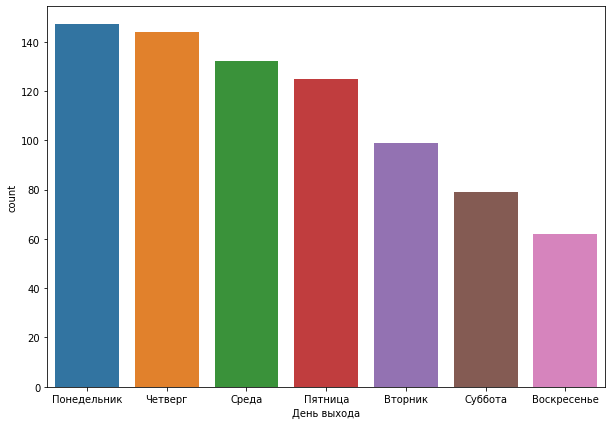

In [537]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.countplot(ax=ax, data=dataset, order=dataset['День выхода'].value_counts().index, x='День выхода');

Можно сказать, что самые популярные фильмы по мнению пользователей кинопоиска (далее просто фильмы) чаще выходят по будням, но в целом, день выхода фильма не влияет на то станет он популярным (это как бы логично)

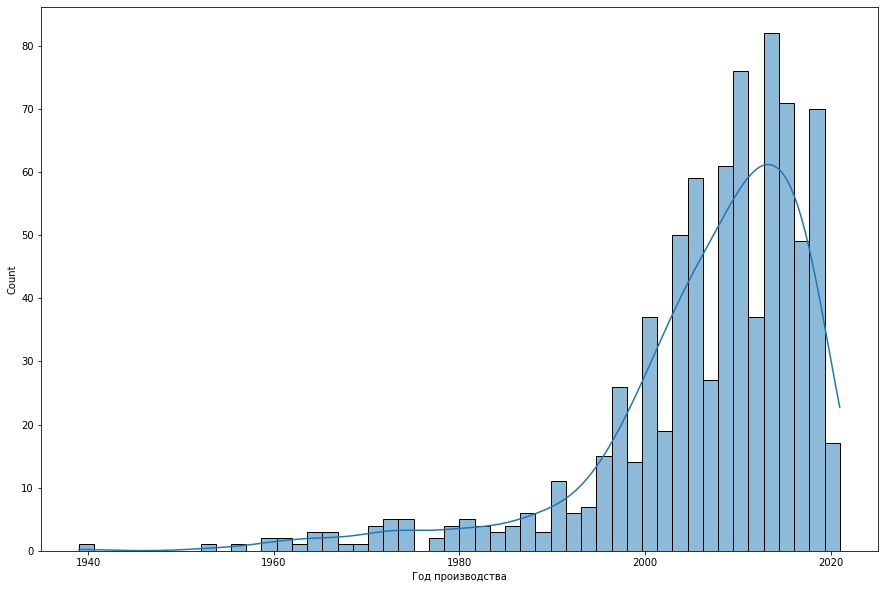

In [657]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(dataset['Год производства'], ax=ax, kde=True, bins=50);

Можно сказать, что конец нулевых - начало десятых - время выпуска самых популярных фильмов

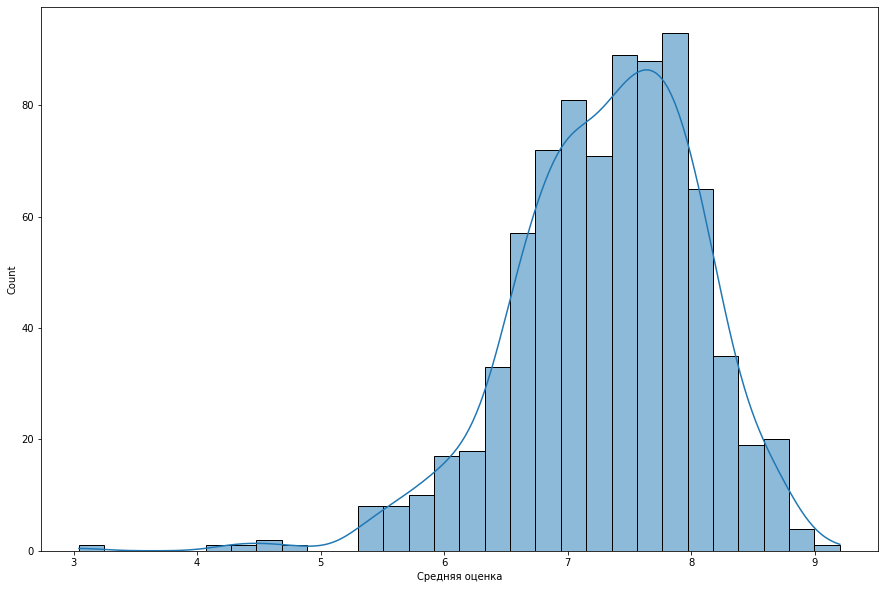

In [663]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(dataset['Средняя оценка'], ax=ax, bins=30, kde=True);

Самые популярные фильмы в большинстве своем оцениваются зрителями хорошо или отлично

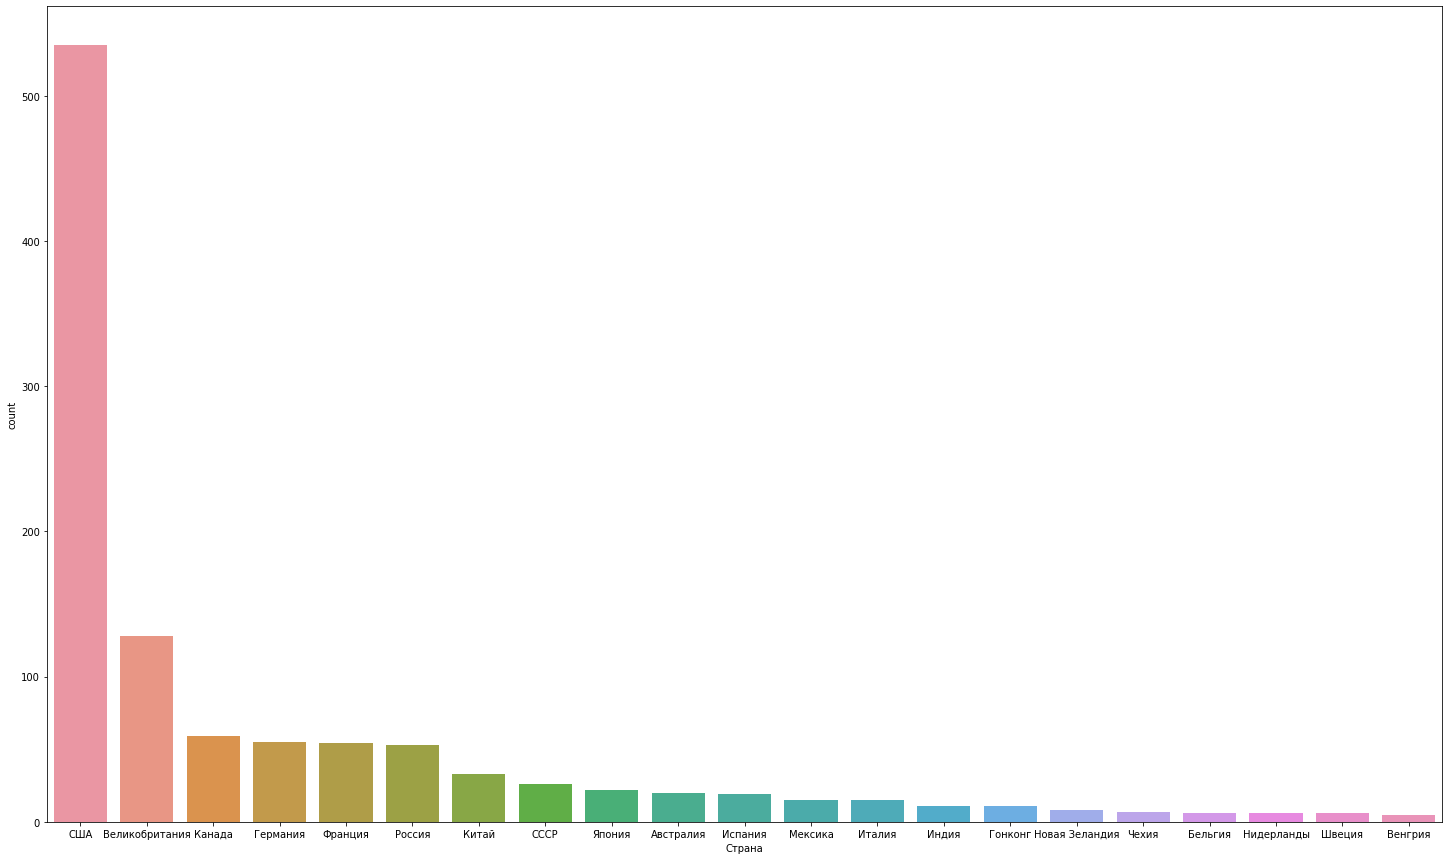

In [554]:
countries = []
for country in dataset['Страна']:
    if type(country) == str:
        countries.append(country)
    else:
        countries = countries + country
for i in set(countries):
    if countries.count(i) < 5:
        countries = list(filter(lambda x: x != i, countries))
countries = pd.DataFrame({'Страна': countries})
fig, ax = plt.subplots(figsize=(25, 15))
sns.countplot(ax=ax, data=countries, order=countries['Страна'].value_counts().index, x='Страна');

Определенно, США являются абсолютным лидером в производстве массовых фильмов (2 место (Великобритания) отстает почти в 5 раз)

In [520]:
directors = []
for i, (x, y) in dataset[['Режиссер', 'Средняя оценка']].iterrows():
    if type(x) == list:
        for j in x:
            directors.append((j, y))
    else:
        directors.append((x, y))
directors = pd.DataFrame(directors, columns=['Режиссер', 'Средняя оценка'])
directors = directors.groupby('Режиссер').agg(Average=('Средняя оценка', 'mean'),
                                              Count=('Средняя оценка', 'count')).reset_index().sort_values('Count',
                                                                                                           ascending=False)
directors[['Режиссер', 'Count']].head(5)

,Режиссер,Count
360,Стивен Спилберг,12
310,Ридли Скотт,10
241,Майкл Бэй,10
78,Гай Ричи,10
217,Кристофер Нолан,9


Можно сказать, что представленные выше режиссеры являются авторами наибольшего количества популярных фильмов, самым популярным режиссером можно назвать Стивена Спилберга

In [521]:
directors[directors['Count'] >= 3].sort_values('Average', ascending=False)[['Режиссер', 'Average']].head(5)

,Режиссер,Average
408,Фрэнсис Форд Коппола,8.664000
232,Леонид Гайдай,8.479400
404,Фрэнк Дарабонт,8.457667
321,Роберт Земекис,8.255000
217,Кристофер Нолан,8.230556


Предствленные выше авторы являются авторами нескольких лучших (субъективно но кинопоиск + IMDb) популярных фильмов

In [522]:
dataset.sort_values('Средняя оценка', ascending=False)[['Режиссер', 'Страна', 'Средняя оценка']].head(5)

,Режиссер,Страна,Средняя оценка
Название,,,
Побег из Шоушенка,Фрэнк Дарабонт,США,9.2045
Крестный отец,Фрэнсис Форд Коппола,США,8.9605
Список Шиндлера,Стивен Спилберг,США,8.8585
Форрест Гамп,Роберт Земекис,США,8.8545
Зеленая миля,Фрэнк Дарабонт,США,8.8305


Самые лучшие фильмы по мнению пользователей

In [526]:
categories = dataset.groupby('Возраст').agg({'Средняя оценка': 'max'}).reset_index()
age_categories = pd.merge(dataset, categories, on='Средняя оценка', how="right",
                          suffixes=('', '1'))[['Название', 'Страна', 'Режиссер', 'Возраст', 'Средняя оценка']]
display(age_categories)
categories = dataset.groupby('Рейтинг MPAA').agg({'Средняя оценка': 'max'}).reset_index()
mpaa_categories = pd.merge(dataset, categories, on='Средняя оценка', how="right",
                           suffixes=('', '1'))[['Название', 'Страна', 'Режиссер', 'Рейтинг MPAA', 'Средняя оценка']]
display(mpaa_categories)

,Название,Страна,Режиссер,Возраст,Средняя оценка
0,Бриллиантовая рука,СССР,Леонид Гайдай,0+,8.4545
1,Форрест Гамп,США,Роберт Земекис,12+,8.8545
2,Побег из Шоушенка,США,Фрэнк Дарабонт,16+,9.2045
3,Криминальное чтиво,США,Квентин Тарантино,18+,8.7600
4,Операция «Ы» и другие приключения Шурика,СССР,Леонид Гайдай,6+,8.6545


,Название,Страна,Режиссер,Рейтинг MPAA,Средняя оценка
0,Операция «Ы» и другие приключения Шурика,СССР,Леонид Гайдай,PG,8.6545
1,Форрест Гамп,США,Роберт Земекис,PG-13,8.8545
2,Побег из Шоушенка,США,Фрэнк Дарабонт,R,9.2045


Лучшие фильмы по разным системам возрастных категорий

In [528]:
categories = dataset.groupby('Десятилетие').agg({'Средняя оценка': 'max'}).reset_index()
year_categories = pd.merge(dataset, categories, on=['Средняя оценка', 'Десятилетие'], how="right",
                           suffixes=('', '1'))[
    ['Название', 'Страна', 'Режиссер', 'Десятилетие', 'Средняя оценка']].sort_values('Средняя оценка', ascending=False)
year_categories

,Название,Страна,Режиссер,Десятилетие,Средняя оценка
8,Побег из Шоушенка,США,Фрэнк Дарабонт,90-е,9.2045
6,Крестный отец,США,Фрэнсис Форд Коппола,70-е,8.9605
0,Властелин колец: Возвращение короля,США,Питер Джексон,0-е,8.7665
4,12 разгневанных мужчин,США,Сидни Люмет,50-е,8.7570
1,Начало,Великобритания,Кристофер Нолан,10-е,8.7300
5,"Хороший, плохой, злой","[Италия, Испания, Германия (ФРГ)]",Серджио Леоне,60-е,8.6570
7,Приключения Шерлока Холмса и доктора Ватсона: ...,СССР,Игорь Масленников,80-е,8.6505
3,Унесенные ветром,США,"[Виктор Флеминг, Джордж Кьюкор, Сэм Вуд]",30-е,8.2375
2,Лига справедливости Зака Снайдера,Великобритания,Зак Снайдер,20-е,8.0395


Лучшие фильмы по десятилетиям (можно отметить что лучшие фильмы были сняты в конце прошлого - начале этого века)

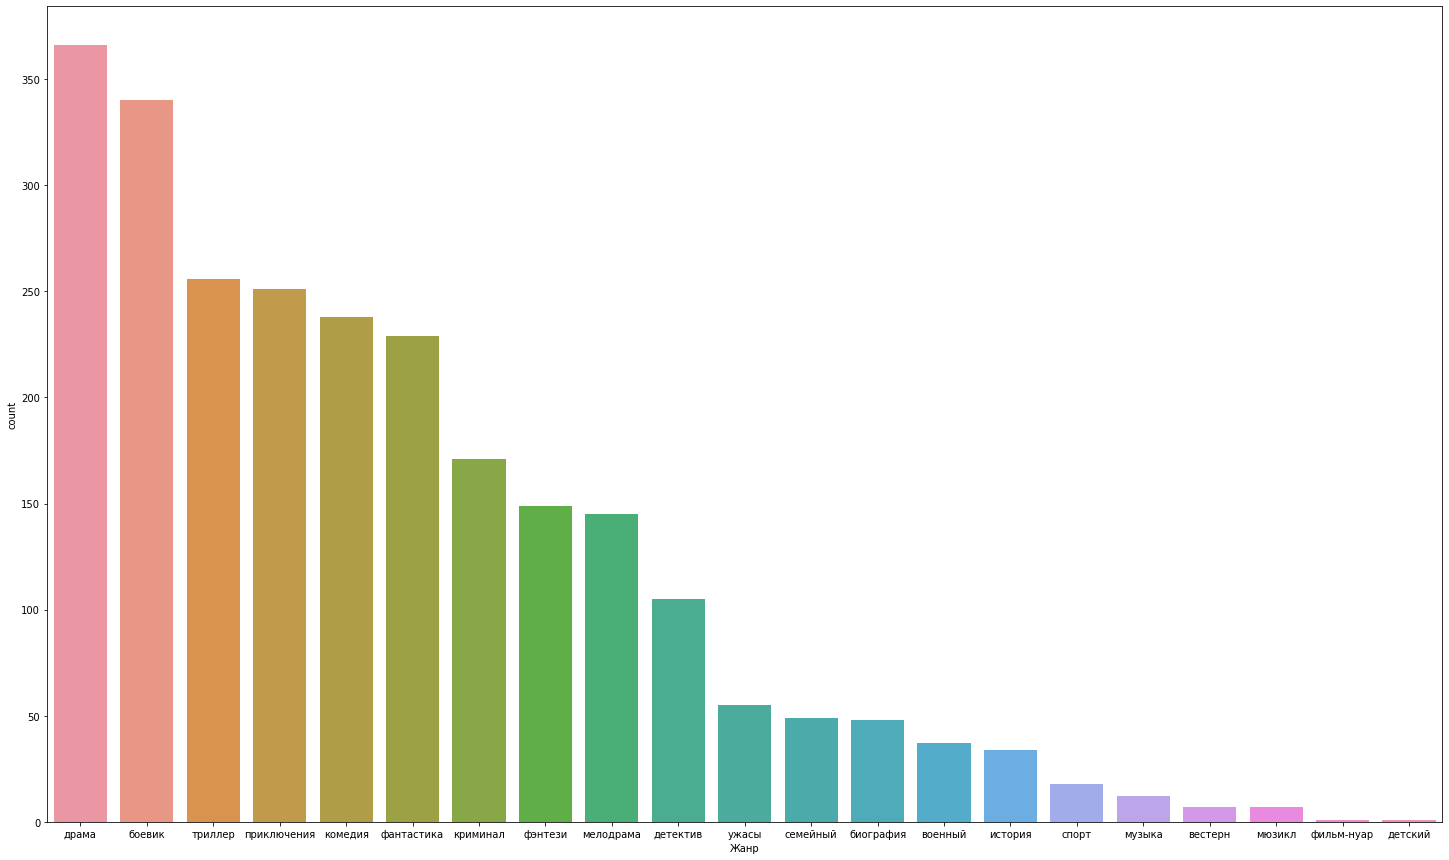

In [535]:
genres = []
for genre in dataset['Жанр']:
    if type(genre) == str:
        genres.append(genre)
    else:
        genres = genres + genre
genres = pd.DataFrame({'Жанр': genres})
fig, ax = plt.subplots(figsize=(25, 15))
sns.countplot(ax=ax, data=genres, order=genres['Жанр'].value_counts().index, x='Жанр');

Самыми популярными жанрами, среди самых популярных фильмов являются такие жанры как: "драма" и "боевик", тогда как фильмы в жанрах "мюзикл", "вестерн", "музыка", "фильм-нуар", "детский" редко становится очень популярными

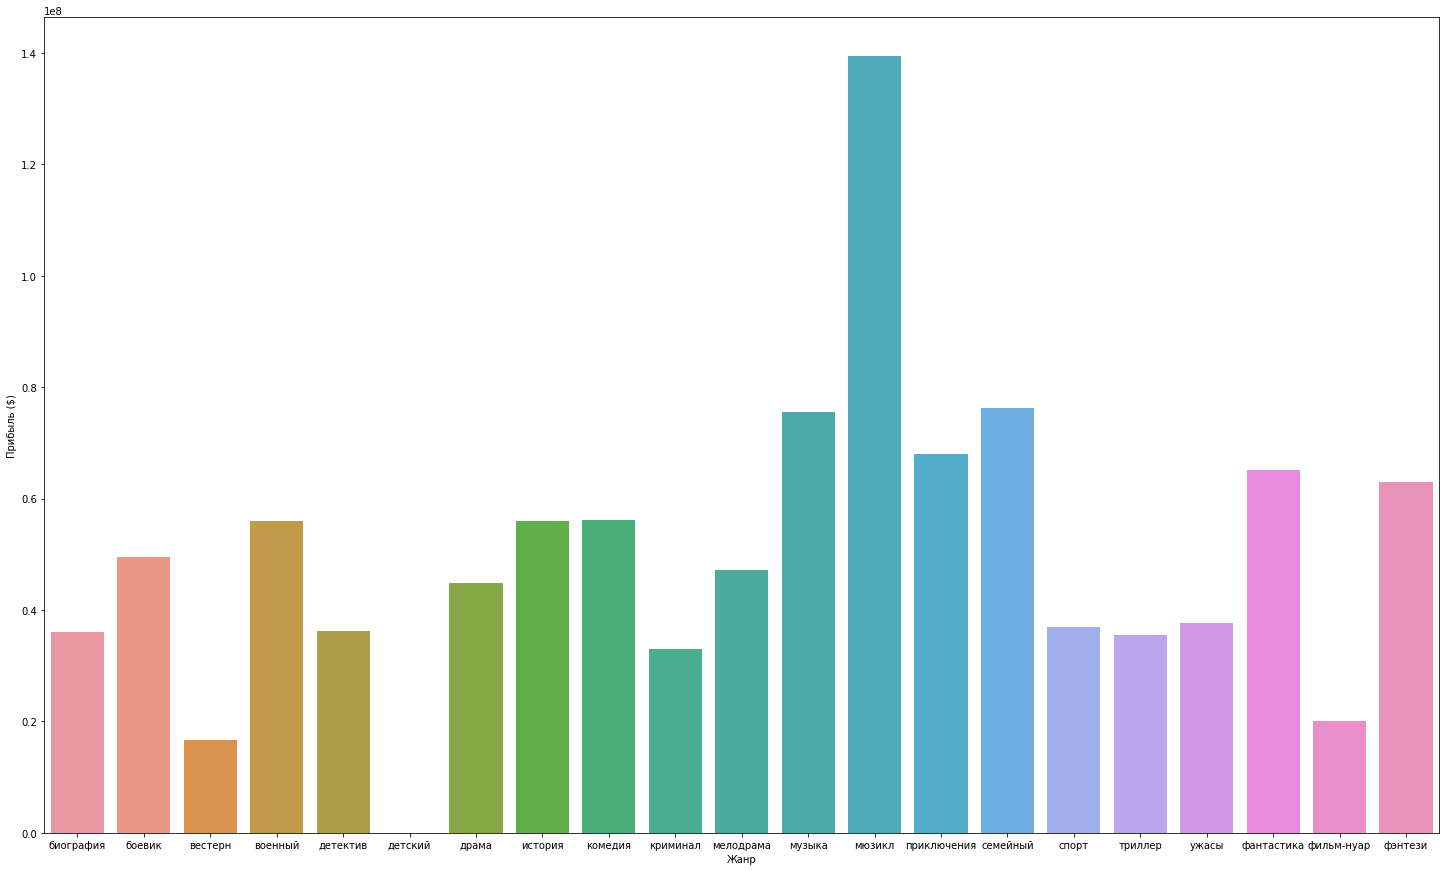

In [635]:
genres_n_profit_list = []
for i, row in dataset[['Жанр', 'Прибыль ($)']].iterrows():
    if type(row['Жанр']) == str:
        genres_n_profit_list.append((row['Жанр'], row['Прибыль ($)']))
    else:
        for genre in row['Жанр']:
            genres_n_profit_list.append((genre, row['Прибыль ($)']))
genres_n_profit = pd.DataFrame(genres_n_profit_list, columns=['Жанр', 'Прибыль ($)'])
genres_n_profit = genres_n_profit.groupby('Жанр').agg({'Прибыль ($)': 'mean'}).reset_index()
fig, ax = plt.subplots(figsize=(25, 15))
sns.barplot(ax=ax, x='Жанр', y='Прибыль ($)', data=genres_n_profit);

Удивительно, но самым прибыльным жанром считается мюзикл, при том, что количество фильмов в этом жанре мало, поэтому построим этот график для жанров, количество фильмов по которым больше 10

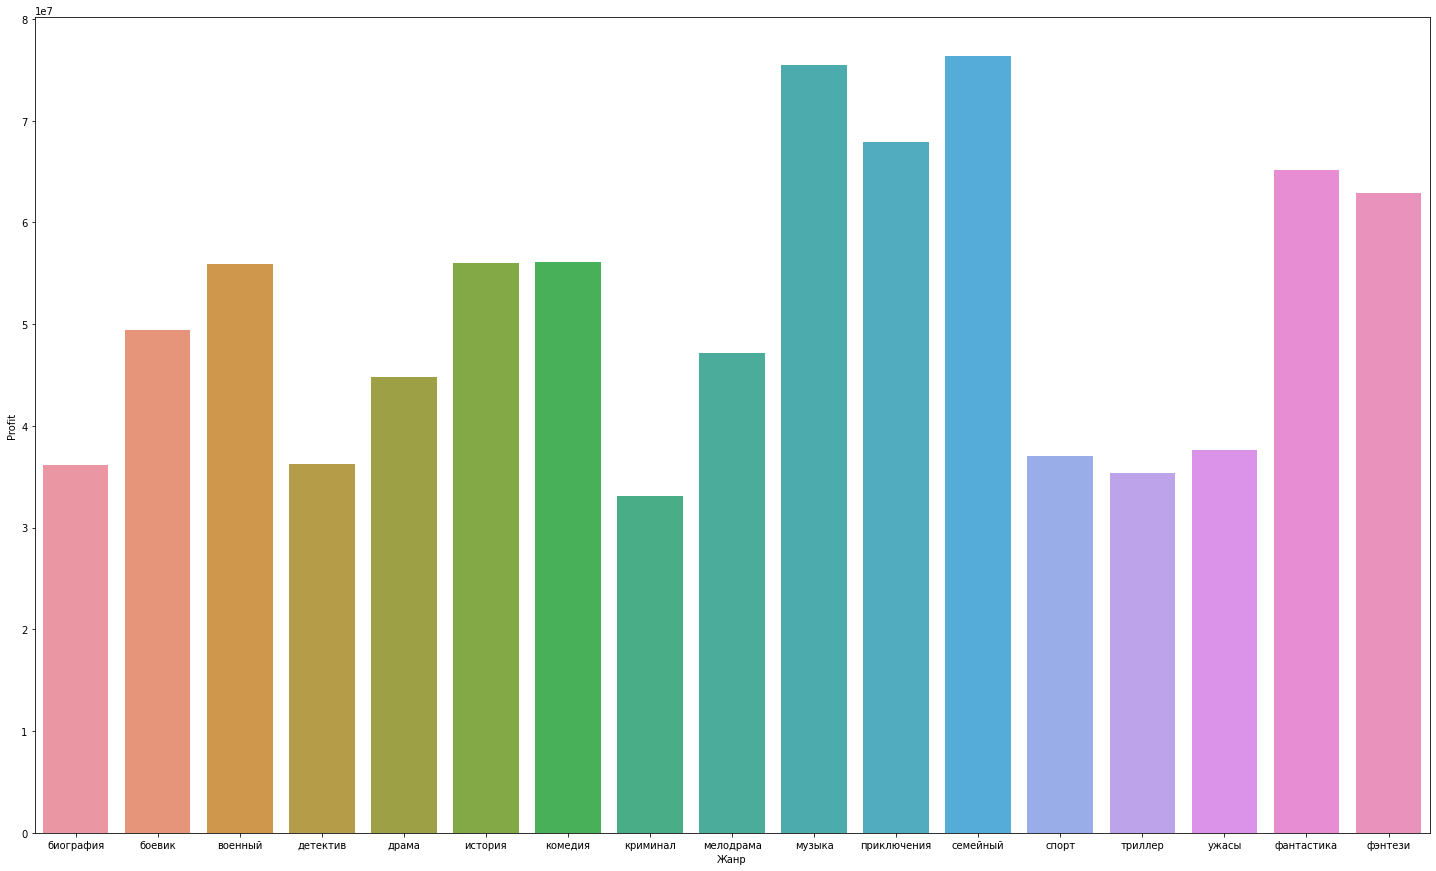

In [636]:
genres_n_profit_more_10 = pd.DataFrame(genres_n_profit_list, columns=['Жанр', 'Прибыль ($)'])
genres_n_profit_more_10 = genres_n_profit_more_10.groupby('Жанр').agg(Profit=('Прибыль ($)', 'mean'),
                                                                      Count=('Жанр', 'count')).reset_index()
genres_n_profit_more_10 = genres_n_profit_more_10[genres_n_profit_more_10['Count'] > 10]
fig, ax = plt.subplots(figsize=(25, 15))
sns.barplot(ax=ax, x='Жанр', y='Profit', data=genres_n_profit_more_10);

Теперь с уверенностью можно сказать, что самыми прибыльными популярными фильмами являются фильмы таких жанров как: "Музыка", "Приключения", "Фантастика", "Семейный", "Фэнтези". В целом нет жанров, которые среди популярных фильмов имеют низкую прибыль (что возможно логично, ведь они популярные)

In [687]:
corr = dataset[
    ['Прибыль ($)', 'Количество оценок на Кинопоиск', 'Количество оценок на IMDb', 'Средняя оценка', 'Бюджет ($)',
     'Сборы в США ($)']].corr()
corr.style.background_gradient(cmap = 'magma')

,Прибыль ($),Количество оценок на Кинопоиск,Количество оценок на IMDb,Средняя оценка,Бюджет ($),Сборы в США ($)
Прибыль ($),1.000000,0.354220,0.426497,0.229366,0.113443,0.842360
Количество оценок на Кинопоиск,0.354220,1.000000,0.559290,0.458484,0.186598,0.338841
Количество оценок на IMDb,0.426497,0.559290,1.000000,0.505840,0.119901,0.396128
Средняя оценка,0.229366,0.458484,0.505840,1.000000,-0.242821,0.013993
Бюджет ($),0.113443,0.186598,0.119901,-0.242821,1.000000,0.630996
Сборы в США ($),0.842360,0.338841,0.396128,0.013993,0.630996,1.000000


В представленных фильмах есть умеренная корреляция между количеством оценок на разных ресурсах и средней оценки с количеством оценок. Это говорит о том, то более оцениваемые фильмы имеют более выоскую среднюю оценку. Также присутсвует высокая зависимость между сборами в США и прибылью, что свидетельствует о том, что фильмы часто окупали себя в несколько раз, так же есть высокая зависимость между сборами в США и бюджетом, что говорит о том, что фильмы, на которые выделен большой бюджет, с большей вероятностью будут иметь большие сборы.

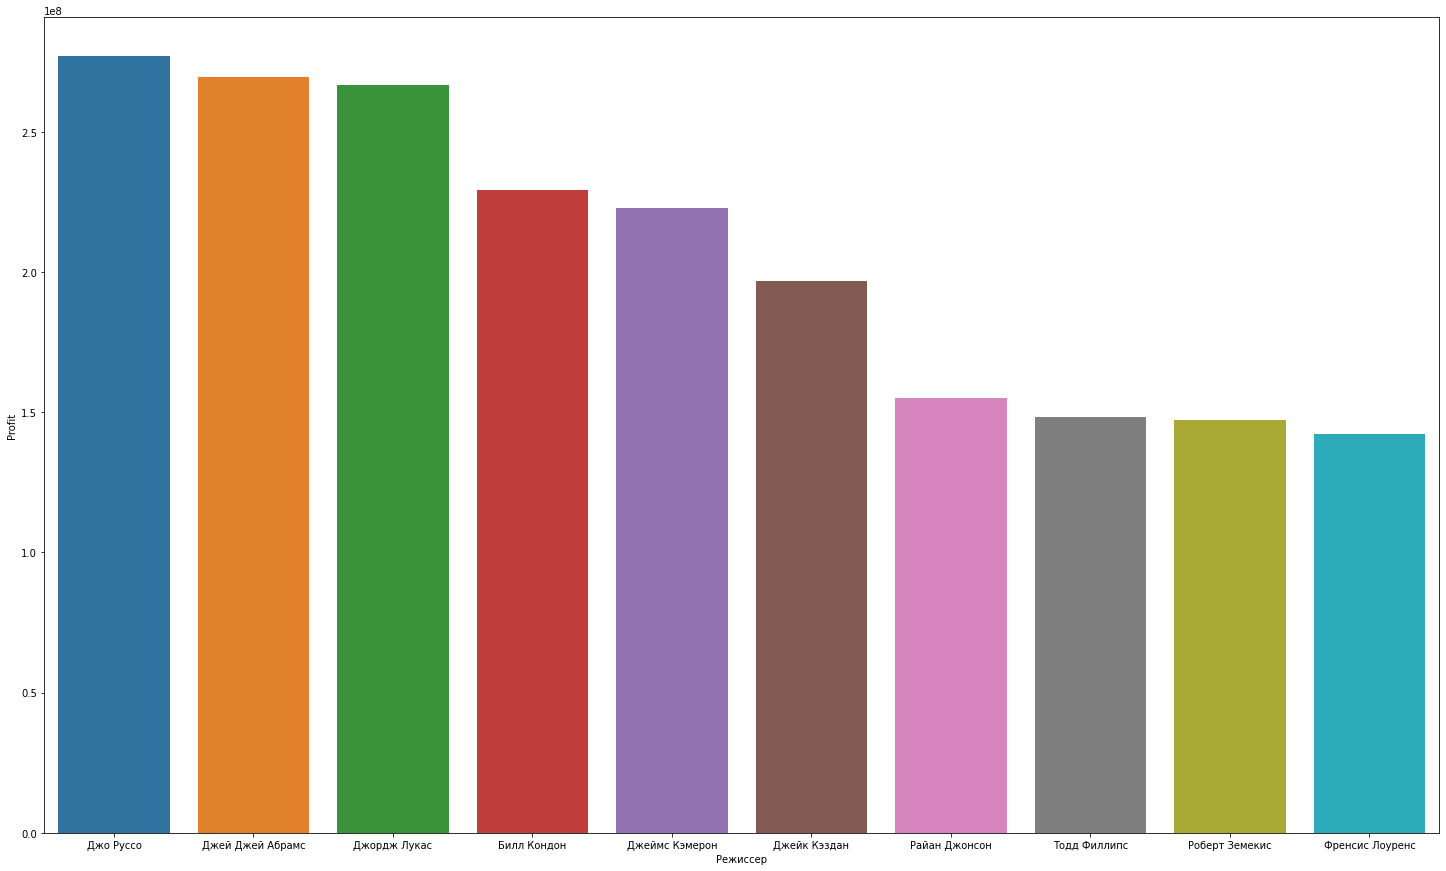

In [665]:
directors_n_profit = dataset[['Режиссер', 'Прибыль ($)']].dropna()
directors = []
for i, (x, y) in directors_n_profit[['Режиссер', 'Прибыль ($)']].iterrows():
    if type(x) == list:
        for j in x:
            directors.append((j, y))
    else:
        directors.append((x, y))
directors_n_profit = pd.DataFrame(directors, columns=['Режиссер', 'Прибыль ($)'])
directors_n_profit = directors_n_profit.groupby('Режиссер').agg(Profit=('Прибыль ($)', 'mean'),
                                                                Count=('Режиссер', 'count'))
directors_n_profit = directors_n_profit[directors_n_profit['Count'] >= 3].reset_index().sort_values('Profit',
                                                                                                    ascending=False)
fig, ax = plt.subplots(figsize=(25, 15))
sns.barplot(ax=ax, x='Режиссер', y='Profit', data=directors_n_profit.head(10));

Режиссером самых прибыльных среди популярных фильмов является  Джо Руссо

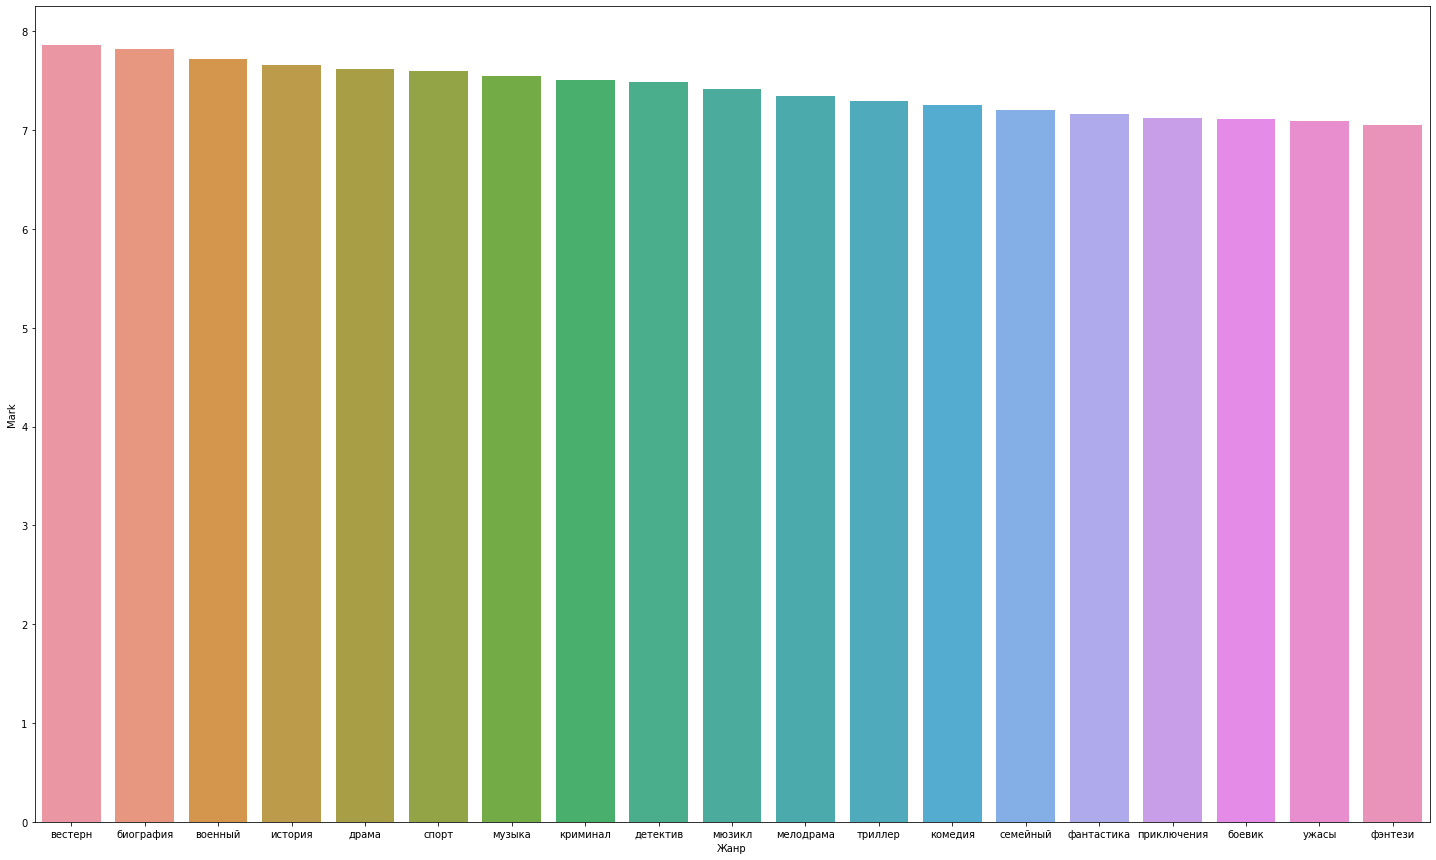

In [676]:
genres_n_mark_list = []
for i, row in dataset[['Жанр', 'Средняя оценка']].iterrows():
    if type(row['Жанр']) == str:
        genres_n_mark_list.append((row['Жанр'], row['Средняя оценка']))
    else:
        for genre in row['Жанр']:
            genres_n_mark_list.append((genre, row['Средняя оценка']))
genres_n_mark = pd.DataFrame(genres_n_mark_list, columns=['Жанр', 'Средняя оценка'])
genres_n_mark = genres_n_mark.groupby('Жанр').agg(Mark=('Средняя оценка', 'mean'),
                                                Count=('Жанр', 'count')).reset_index()
genres_n_mark = genres_n_mark[genres_n_mark['Count'] > 3].sort_values('Mark', ascending=False)
fig, ax = plt.subplots(figsize=(25, 15))
sns.barplot(ax=ax, x='Жанр', y='Mark', data=genres_n_mark);

Сильные отличия в средней по жанрам оценке отсутсвуют, но пользователям больше нравтся фильмы жанров "вестрн" и "биография", нежели "ужасы" или "фэнтези"

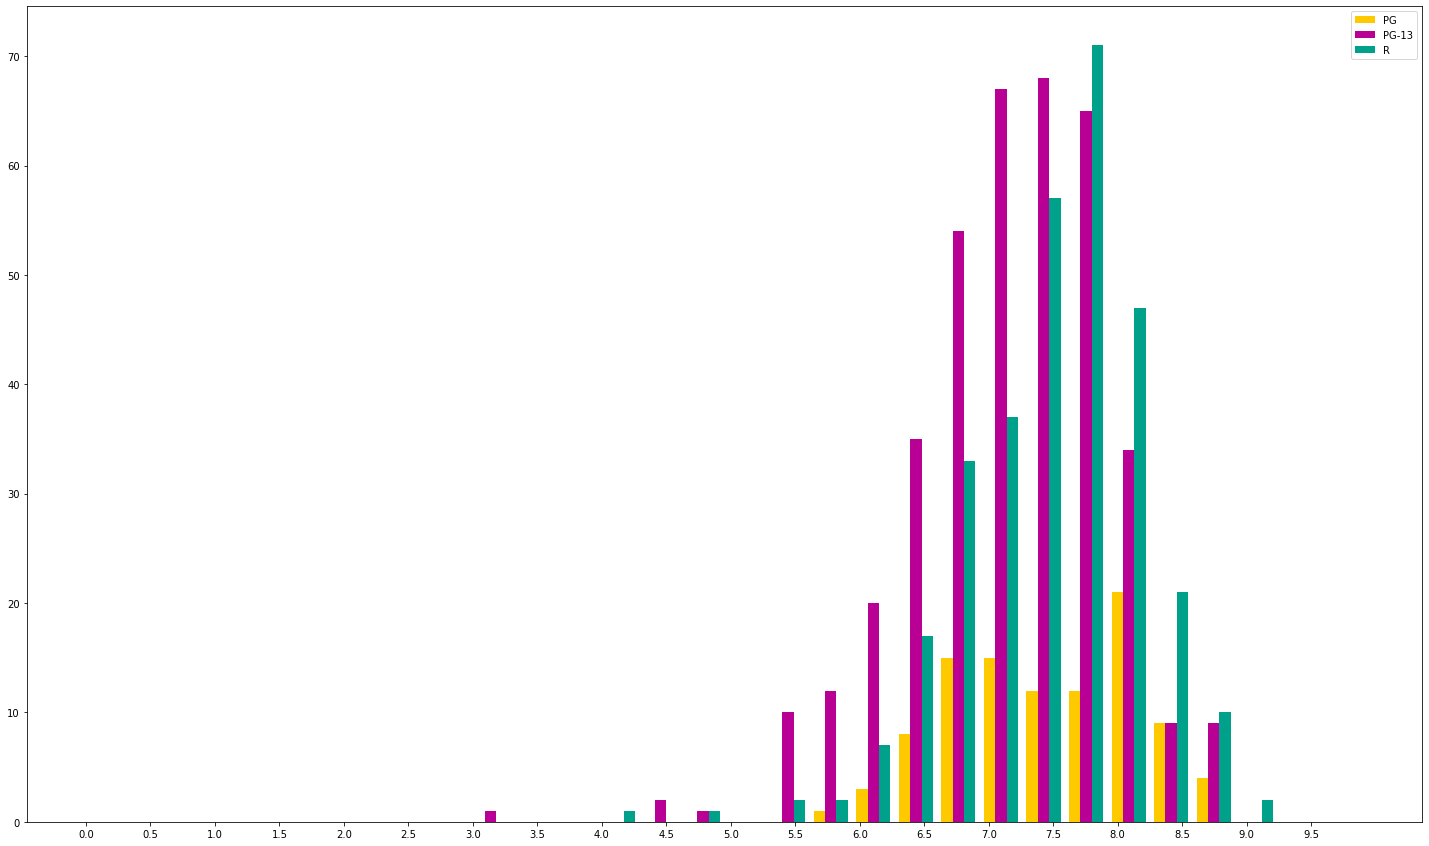

In [715]:
PG = list(list(dataset.groupby('Рейтинг MPAA')['Средняя оценка'])[0][1])
PG_13 = list(list(dataset.groupby('Рейтинг MPAA')['Средняя оценка'])[1][1])
R = list(list(dataset.groupby('Рейтинг MPAA')['Средняя оценка'])[2][1])
fig, ax = plt.subplots(figsize=(25, 15))
ax.hist(x = [PG, PG_13, R], color = [(1,0.79,0),(0.72,0,0.58), (0,0.63,0.54)], label=['PG', 'PG-13', 'R'],
        bins = np.arange(0,10,0.33));
ax.legend()
ax.xaxis.set_ticks(np.arange(0,10,0.5))
ax.xlabel = 'Средняя оценка'
ax.ylabel= 'Количество фильмов'

Количество фильмов с ретингом R стновится больше, чем PG-13 или PG, начиная с 7,5. И в целом оказывается, что фильмы рейтинга R лучше чем остальные, по оценкам на сайтах